In [4]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


NVIDIA A30
(872, 4500, 14) (872,)


# Wasserstein GAN

In [11]:
def train_conv1d_wgan_raw_stable(normal_data, device, n_epochs=50, batch_size=32, lr_g=0.00005, lr_d=0.0001):
    """
    ULTRA-STABLE WGAN training for raw sensor data
    """
    latent_dim = 100
    
    # Enhanced data preprocessing
    print(f"Original data range: [{normal_data.min():.4f}, {normal_data.max():.4f}]")
    
    # Robust scaling with outlier clipping
    data_std = np.std(normal_data)
    data_mean = np.mean(normal_data)
    scaled_data = (normal_data - data_mean) / (data_std + 1e-8)
    
    # CRITICAL: Clip extreme outliers
    scaled_data = np.clip(scaled_data, -3, 3)
    print(f"Clipped scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")
    
    # Initialize models
    generator = Conv1DGeneratorStable(latent_dim).to(device)
    discriminator = Conv1DDiscriminatorEnhanced().to(device)  # Enhanced discriminator
    
    # CRITICAL: FIXED weight initialization with proper checks
    def weights_init_ultra_stable(m):
        if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
            if hasattr(m, 'weight') and m.weight is not None:
                nn.init.normal_(m.weight, 0.0, 0.01)  # Smaller weights
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            if hasattr(m, 'weight') and m.weight is not None:
                nn.init.normal_(m.weight, 0.0, 0.01)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm1d, nn.InstanceNorm1d)):
            if hasattr(m, 'weight') and m.weight is not None:
                nn.init.normal_(m.weight, 1.0, 0.01)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    generator.apply(weights_init_ultra_stable)
    discriminator.apply(weights_init_ultra_stable)
    
    # CRITICAL: Enhanced optimizer settings
    optimizer_G = optim.RMSprop(generator.parameters(), lr=lr_g, alpha=0.99, eps=1e-8)
    optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr_d, alpha=0.99, eps=1e-8)
    
    # CRITICAL: More conservative training parameters
    lambda_gp = 0.01  # Very low gradient penalty
    n_critic = 5      # More critic updates
    clip_value = 0.01 # Very tight gradient clipping
    
    # Create dataloader with larger batch size
    dataset = TensorDataset(torch.tensor(scaled_data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    print("Starting ULTRA-STABLE WGAN training...")
    print(f"Learning rates - Generator: {lr_g}, Discriminator: {lr_d}")
    
    # Enhanced tracking
    d_losses_history = []
    g_losses_history = []
    
    for epoch in range(n_epochs):
        d_losses = []
        g_losses = []
        unstable_count = 0
        
        for i, (real_samples,) in enumerate(dataloader):
            real_samples = real_samples.to(device)
            batch_size_actual = real_samples.size(0)
            
            # Train Discriminator (multiple times)
            for critic_iter in range(n_critic):
                optimizer_D.zero_grad()
                
                # Real samples
                real_validity = discriminator(real_samples)
                
                # Fake samples
                z = torch.randn(batch_size_actual, latent_dim).to(device)
                fake_samples = generator(z).detach()
                fake_validity = discriminator(fake_samples)
                
                # Enhanced gradient penalty with more safety
                try:
                    gp = compute_gradient_penalty_enhanced(discriminator, real_samples, fake_samples, device)
                except Exception as e:
                    print(f"GP failed: {e}")
                    gp = torch.tensor(0.0, device=device)
                
                # WGAN-GP loss with enhanced stability
                wasserstein_distance = torch.mean(real_validity) - torch.mean(fake_validity)
                d_loss = -wasserstein_distance + lambda_gp * gp
                
                # Enhanced safety checks
                if (torch.isnan(d_loss) or torch.isinf(d_loss) or 
                    abs(d_loss.item()) > 50 or
                    abs(wasserstein_distance.item()) > 25):
                    print(f"⚠️  D loss unstable: {d_loss.item():.4f}, WD: {wasserstein_distance.item():.4f}")
                    unstable_count += 1
                    continue
                
                d_loss.backward()
                
                # CRITICAL: Very tight gradient clipping
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), clip_value)
                
                optimizer_D.step()
                
                if critic_iter == n_critic - 1:
                    d_losses.append(d_loss.item())
            
            # Train Generator (FIXED: Better frequency)
            if len(d_losses) > 0 and i % n_critic == 0:  # Train after every n_critic discriminator updates
                optimizer_G.zero_grad()
                
                z = torch.randn(batch_size_actual, latent_dim).to(device)
                fake_samples = generator(z)
                fake_validity = discriminator(fake_samples)
                
                # WGAN generator loss
                g_loss = -torch.mean(fake_validity)
                
                # Enhanced safety check
                if (torch.isnan(g_loss) or torch.isinf(g_loss) or 
                    abs(g_loss.item()) > 50):
                    print(f"⚠️  G loss unstable: {g_loss.item():.4f}")
                    unstable_count += 1
                    continue
                
                g_loss.backward()
                
                # CRITICAL: Tight gradient clipping
                torch.nn.utils.clip_grad_norm_(generator.parameters(), clip_value)
                
                optimizer_G.step()
                
                g_losses.append(g_loss.item())
        
        # Enhanced progress monitoring
        avg_d_loss = np.mean(d_losses) if d_losses else 0
        avg_g_loss = np.mean(g_losses) if g_losses else 0
        
        d_losses_history.append(avg_d_loss)
        g_losses_history.append(avg_g_loss)
        
        # Print progress every epoch
        print(f"Epoch [{epoch}/{n_epochs}]:")
        print(f"  D Loss: {avg_d_loss:.4f}")
        print(f"  G Loss: {avg_g_loss:.4f}")
        print(f"  Unstable Updates: {unstable_count}")
        
        # Enhanced stability indicators
        if len(d_losses_history) >= 5:
            recent_d_std = np.std(d_losses_history[-5:])
            recent_g_std = np.std(g_losses_history[-5:])
            
            if recent_d_std < 0.5 and recent_g_std < 0.5 and abs(avg_d_loss) < 5:
                print("  ✅ Training highly stable")
            elif recent_d_std < 2.0 and recent_g_std < 2.0 and abs(avg_d_loss) < 15:
                print("  🔄 Training moderately stable")
            else:
                print("  ⚠️  Training showing instability")
        
        # Early stopping for severe instability
        if unstable_count > len(dataloader) * 0.3 or abs(avg_d_loss) > 100:
            print("💥 Training too unstable! Stopping early.")
            break
    
    return generator, discriminator, d_losses_history, g_losses_history

def compute_gradient_penalty_enhanced(discriminator, real_samples, fake_samples, device):
    """
    Enhanced gradient penalty with better stability
    """
    batch_size = real_samples.size(0)
    
    # Use multiple interpolation points for stability
    alpha = torch.rand(batch_size, 1, 1).to(device)
    alpha = alpha.expand_as(real_samples)
    
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Add small noise for regularization
    interpolates = interpolates + 0.001 * torch.randn_like(interpolates)
    
    try:
        d_interpolates = discriminator(interpolates)
        
        gradients = grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates).to(device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        gradients = gradients.reshape(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        
        # Clamp to prevent explosion
        return torch.clamp(gradient_penalty, 0, 10)
        
    except Exception as e:
        print(f"Enhanced GP computation failed: {e}")
        return torch.tensor(0.0, device=device)

# Enhanced Discriminator with better stability
class Conv1DDiscriminatorEnhanced(nn.Module):
    def __init__(self, n_features=14, seq_len=4500):
        super(Conv1DDiscriminatorEnhanced, self).__init__()
        
        # More conservative architecture
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(n_features, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1),  # Smaller leak
            nn.Dropout(0.1),
            
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm1d(256),
            nn.LeakyReLU(0.1),
        )
        
        self.conv_output_size = self._get_conv_output_size(seq_len)
        
        # Smaller, more stable classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 * self.conv_output_size, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def _get_conv_output_size(self, seq_len):
        size = seq_len
        for _ in range(5):  # 5 conv layers
            size = (size - 4 + 2) // 2 + 1
        return size

    def forward(self, x):
        x = x.transpose(1, 2)
        features = self.conv_blocks(x)
        features = features.view(features.shape[0], -1)
        return self.classifier(features)


# Stable Generator Architecture
class Conv1DGeneratorStable(nn.Module):
    def __init__(self, latent_dim=100, n_features=14, seq_len=4500):
        super(Conv1DGeneratorStable, self).__init__()
        self.latent_dim = latent_dim
        self.n_features = n_features
        self.seq_len = seq_len
        
        self.init_size = seq_len // 64
        
        # More conservative architecture for raw data
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size),  # Smaller initial size
            nn.BatchNorm1d(128 * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose1d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose1d(4, n_features, kernel_size=4, stride=2, padding=1),
            # NO final activation for raw data
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size)
        out = self.conv_blocks(out)
        
        if out.shape[2] != self.seq_len:
            out = nn.functional.interpolate(out, size=self.seq_len, mode='linear', align_corners=False)
        
        return out.transpose(1, 2)


# WGANS Training

Original data range: [-3995.8000, 127440.0000]
Clipped scaled data range: [-0.3825, 3.0000]
Starting ULTRA-STABLE WGAN training...
Learning rates - Generator: 5e-05, Discriminator: 0.0001
Clipped scaled data range: [-0.3825, 3.0000]
Starting ULTRA-STABLE WGAN training...
Learning rates - Generator: 5e-05, Discriminator: 0.0001
⚠️  D loss unstable: -25.9008, WD: 26.0008
⚠️  D loss unstable: -26.2938, WD: 26.3938
⚠️  D loss unstable: -26.5310, WD: 26.6310
⚠️  D loss unstable: -26.5116, WD: 26.6116
⚠️  D loss unstable: -27.0375, WD: 27.1375
⚠️  D loss unstable: -26.8980, WD: 26.9980
⚠️  D loss unstable: -26.4304, WD: 26.5267
⚠️  D loss unstable: -26.6254, WD: 26.7254
⚠️  D loss unstable: -27.1500, WD: 27.2500
⚠️  D loss unstable: -26.1044, WD: 26.2044
⚠️  D loss unstable: -26.2884, WD: 26.3884
⚠️  D loss unstable: -26.2295, WD: 26.3295
⚠️  D loss unstable: -26.0050, WD: 26.1050
⚠️  D loss unstable: -25.9008, WD: 26.0008
⚠️  D loss unstable: -26.2938, WD: 26.3938
⚠️  D loss unstable: -26.5

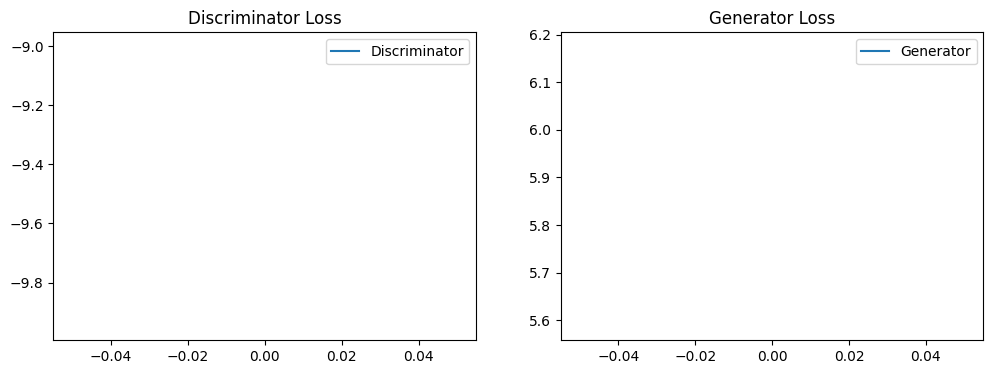

In [12]:
# Use the stable version
trained_generator, trained_discriminator, d_history, g_history = train_conv1d_wgan_raw_stable(
    normal_data, 
    device, 
    n_epochs=25,      # Start with fewer epochs
    batch_size=64,    # Larger batch for stability
    lr_g=0.00005,     # Keep these rates
    lr_d=0.0001
)
# Monitor training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(d_history, label='Discriminator')
plt.title('Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_history, label='Generator')
plt.title('Generator Loss')
plt.legend()
plt.show()

# Generate and Combine

In [ ]:
generator = Generator(latent_dim).to(device)
num_samples = len(data[label == 0])  # Number of synthetic samples to generate
batch_size = 64  # Generate in batches to avoid memory issues

generated_list = []
for i in range(0, num_samples, batch_size):
	current_batch = min(batch_size, num_samples - i)
	z = torch.randn(current_batch, latent_dim).to(device)
	with torch.no_grad():
		batch_samples = generator(z).cpu().numpy()
	# batch_samples shape: (current_batch, 14, 10, 15, 30)
	batch_samples = batch_samples.reshape(current_batch, 14, -1).transpose(0, 2, 1)  # (current_batch, 4500, 14)
	generated_list.append(batch_samples)

generated_samples = np.concatenate(generated_list, axis=0)  # (num_samples, 4500, 14)

combine_data_normal = np.concatenate((generated_samples, normal_data), axis=0)  # Combine real and generated data
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)  # Labels: 0 for generated, 1 for real

# Processing: Mel Spec > Resizing > Feature Extraction

In [ ]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

# AE Class

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data):
    model.eval()
    x = torch.tensor(data.reshape(-1, 4096), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    loss = []
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            loss.extend(batch_errors.cpu().numpy())
    return np.array(loss)

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    # Step 1: Flatten the test data
    n_samples, n_segments, n_features = X_test.shape
    X_test_flat = X_test.reshape(-1, n_features)

    # Step 2: Compute reconstruction errors per segment
    segment_errors = compute_reconstruction_loss(model, X_test_flat)

    # Step 3: Aggregate errors per sample (mean over segments)
    sample_errors = segment_errors.reshape(n_samples, n_segments).mean(axis=1)

    # Step 4: Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(sample_errors.min(), sample_errors.max(), 100):
        preds = (sample_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Step 5: Predict using best threshold
    test_preds = (sample_errors > best_threshold).astype(int)

    # Step 6: Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))



# Preprocessing

In [ ]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(combine_data.reshape(-1, combine_data.shape[-1])).reshape(combine_data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)

# Cross Validation with StandardScaler

In [ ]:

for fold, (train_idx, val_idx) in enumerate(skf.split(features, combine_label)):
    
    print(f"Fold {fold + 1}")
    
    # Get full fold data
    fold_data, fold_labels = features[train_idx], combine_label[train_idx]
    val_data, val_labels = features[val_idx], combine_label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=42)

    # Train autoencoder on the training fold
    model = train_autoencoder(X_train[y_train == 0], epochs=15, batch_size=32)

    # Evaluate on validation fold
    val_errors_normal = compute_reconstruction_loss(model, X_val[y_val == 0])
    val_errors_abnormal = compute_reconstruction_loss(model, X_val[y_val == 1])
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    

    val_errors_test = compute_reconstruction_loss(model, X_test)
    

    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)



# Observation:

Accuracy = 0.9166666666666666


Precision = 0.7142857142857143

Recall = 0.3125

F1 Score = 0.43478260869565216

Confusion Matrix:

 [[138   2]

 [ 11   5]]



